### Noise-contrastive estimation: A new estimation principle for unnormalized statistical models
---
Guntmann and Hyvarien state that say we want to model some complex solution using unnormalized statistical models. For high dimensionality problems it is close to impossible to calculate the normalization constant of the Probability Density Function (PDF).

One of examples of such problems are Energy Based models or multi-layer networks, which reference modern Neural Networks. It is both impossible to compute the integral of the Network because of its high complexity and computationally very expensive as well, say by using Softmax, given large number of classes present in the dataset as calculating softmax can be considered a form of finding Z, specifically for discrete and finite scenarios. 

The softmax function computes the normalization factor directly in its denominator (which sums up the exponentials of all outputs) to ensure the outputs form a valid probability distribution. This sum effectively acts as Z by normalizing the values so that their total is 1. So, in natual language processing or image detection with a lot of classes it quickly becomes infeasible / ineffective to compute directly. 

One of the key insights is that any statistical model can be represented by the unnormolized model and normalization constant is treated as a learnable parameter. NCE is here to eliminate the computational cost of softmax normalization by treating it as a binary problem. Basically, by distinguishng between real and fake data. 

Paper proposes new approach to solve the problem. Here are a few key points:

-   > The basic idea is to estimate the parameters by learning to discriminate between the data x and some artificially generated noise y.

-   > ... the noise distribution should be close to the data distribution ...

-   > ... one could choose a noise distribution by first estimating a preliminary model of the data, and then use this preliminary model as the noise distribution.
  
-   > ... we include the normalization constant as another parameter c of the model.

-   > The parameters θ are then estimated by learning to discriminate between the data x and the noise y, i.e. by maximizing J(T) ...

The cost function $J$ is defined as:

$$
\begin{aligned}
J_T(\theta) &= \frac{1}{2T} \sum_{t} \left( \ln [ h(\mathbf{x}_t; \theta) ] + \ln [ 1 - h(\mathbf{y}_t; \theta) ] \right) \\
\text{where} \\
h(u; \theta) &= \frac{1}{1 + \exp[-G(u; \theta)]} \\
G(u; \theta) &= \ln p_m(u; \theta) - \ln p_n(u)
\end{aligned}
$$


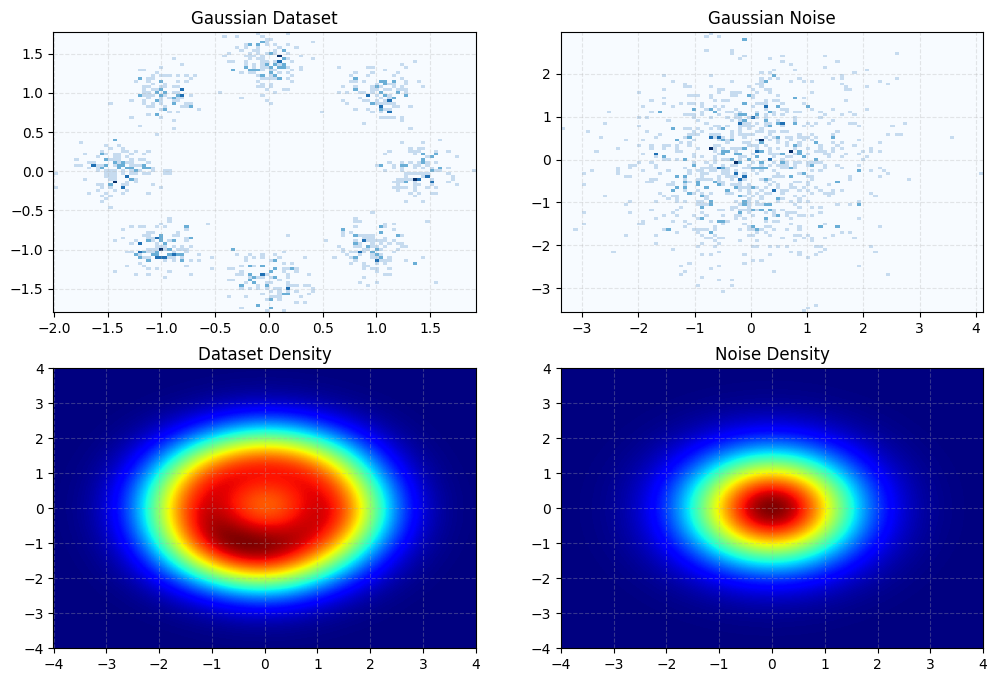

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal

def generate_8_gaussians(n_samples, radius) -> np.ndarray:

    n_centers = 8
    centers = torch.linspace(0, 2 * torch.pi * (n_centers + 1), (n_centers + 1))[:-1]
    centers = torch.stack([radius * torch.cos(centers), radius * torch.sin(centers)], dim = 1)
    # Sample centers N times randomly
    centers = centers[torch.randint(len(centers), size=(n_samples,))]

    # Generate random samples with normal distribution
    Z = torch.randn(n_samples, 2) * 0.5

    # Scale to normalize std of Z to ~ 1.0 and is similar to noise distr.
    scale = 1 / torch.sqrt(centers.std() ** 2 + Z.std() ** 2)
    samples = scale * (Z + centers)

    # Convert to numpy for plotting
    return samples.numpy()


def gaussian_kde_2d(data, bandwidth, N, R):
    assert len(data.shape) == 2, "Should be 2-d array"
    assert data.shape[1] > 1, ""

    x_grid, y_grid = torch.linspace(-R, R, N), torch.linspace(-R, R, N)
    data_x, data_y = data[:, 0], data[:, 1]

    n = len(data_x)
    density = np.zeros((len(y_grid), len(x_grid)))

    for i in range(n):
        kernel_x = np.exp(-0.5 * ((x_grid - data_x[i]) / bandwidth) ** 2) / (bandwidth * np.sqrt(2 * np.pi))
        kernel_y = np.exp(-0.5 * ((y_grid - data_y[i]) / bandwidth) ** 2) / (bandwidth * np.sqrt(2 * np.pi))
        density += np.outer(kernel_y, kernel_x)

    density /= n
    return density

# Parameters
N = 1000
R = 4
range_lim = 1

# Data
gaussian_distr = MultivariateNormal(torch.zeros(2), R * 0.3 * torch.eye(2))
gaussian_dataset = generate_8_gaussians(N, R)
gaussian_noise = gaussian_distr.sample((N,))


# Grid
x = torch.linspace(-R, R, N)
x_grid, y_grid = torch.meshgrid((x, x), indexing='ij')
zz = torch.stack((x_grid.flatten(), y_grid.flatten()), dim=1)

# PDE
bandwidth = .8

dataset_density = gaussian_kde_2d(gaussian_dataset,  bandwidth, N, R)
noise_density = gaussian_distr.log_prob(zz).exp().view(N, N).numpy()

# Plot
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
hist_kwargs = {'bins': 100, "cmap": "Blues"}

axs[0][0].hist2d(x=gaussian_dataset[:, 0], y=gaussian_dataset[:, 1], **hist_kwargs)
axs[0][0].set_title('Gaussian Dataset')
axs[0][0].grid(True, linestyle='--', alpha=0.3)

axs[0][1].hist2d(x=gaussian_noise[:, 0], y=gaussian_noise[:, 1], **hist_kwargs)
axs[0][1].set_title('Gaussian Noise')
axs[0][1].grid(True, linestyle='--', alpha=0.3)

axs[1][0].pcolormesh(x_grid, y_grid, dataset_density, shading='auto', cmap='jet')
axs[1][0].set_title('Dataset Density')
axs[1][0].grid(True, linestyle='--', alpha=0.3)

axs[1][1].pcolormesh(x_grid, y_grid, noise_density, shading='auto', cmap='jet')
axs[1][1].set_title('Noise Density')
axs[1][1].grid(True, linestyle='--', alpha=0.3)

plt.show()


             std          mean
noise  1.0925161  -0.061282773
data     1.00077     -0.028256

Here are both distributiosn stacked:



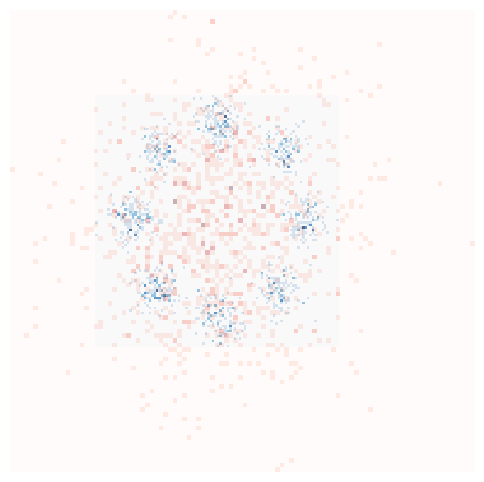

In [3]:
import pandas as pd

data_info = pd.DataFrame(
    columns = ["std", "mean"], 
    index = ["noise", "data"],
    data=[[gaussian_noise.std().numpy(), gaussian_noise.mean().numpy()],
        [gaussian_dataset.std(), gaussian_dataset.mean()]])

text = f"""
{data_info}

Here are both distributiosn stacked:
"""
print(text)

fig, ax = plt.subplots(figsize=(6, 6))

hist_kwargs = {'bins': 100, "cmap": "Blues", 'alpha': 1}
ax.hist2d(gaussian_dataset[:, 0], gaussian_dataset[:, 1], **hist_kwargs)

hist_kwargs = {'bins': 100, 'cmap': 'Reds', 'alpha': 0.3}
ax.hist2d(gaussian_noise[:, 0], gaussian_noise[:, 1], **hist_kwargs)

ax.grid(True, linestyle='--', alpha=0.3)
ax.set_axis_off()
plt.show()

In [22]:
from torch import nn

class NCE(nn.Module):
    def __init__(self, dim) -> None:
        super(NCE, self).__init__()
        # Normalization constant C
        self.c = nn.Parameter(torch.tensor([1.], requires_grad=True))

        self.f = nn.Sequential(
                nn.Linear(dim, 128),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Linear(128, 128),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Linear(128, 1),
            )

    def forward(self, x):
        log_prob = - self.f(x) - self.c
        return log_prob

def nce_loss(model, x, noise_distribution, device):
    current_batch_size = x.shape[0]
    
    y = noise_distribution.sample((current_batch_size,)).to(device)
    
    p_m_x = model(x)                                       # Model output for real data log p_m(x)
    p_m_y = model(y)                                       # Model output for noise data log p_m(y)
    p_n_x = noise_distribution.log_prob(x).unsqueeze(1)    # log p_n(x)
    p_n_y = noise_distribution.log_prob(y).unsqueeze(1)    # log p_n(y)

    # Original
    # h_y = torch.sigmoid(p_m_y - p_n_y)
    # log_h_y = torch.log(1 - h_y)

    # Used for numerical stability since log(sigmoid(x - y)) = 1 - log(sigmoid(y - x))
    h_x = torch.sigmoid(p_m_x - p_n_x)
    h_y = torch.sigmoid(p_n_y - p_m_y)
    log_h_y = torch.log(h_y)
    log_h_x = torch.log(h_x)

    accuracy = ((h_x > 1/2).sum() + (h_y > 1/2).sum()).cpu().numpy() / (len(x) + len(y))
    
    J_x = -(torch.mean(log_h_x + log_h_y) / 2)
    
    return J_x, accuracy

EPOCHS = 50
BATCH_SIZE = 32

# device = torch.device("cuda") if torch.cuda.is_available else torch.device("cpu")
device = torch.device("cpu")
model = NCE(2).to(device)

dataloader = torch.utils.data.DataLoader(gaussian_dataset, batch_size=BATCH_SIZE, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), betas = (0.9, 0.999))

loss_hist, acc_hist = [], []

for epoch in range(EPOCHS):
    for i, x in enumerate(dataloader):           
        # x -> for true data
        # y -> for noise data
        x = x.to(device)
        optimizer.zero_grad()

        loss, accuracy = nce_loss(model, x, gaussian_distr, device)

        loss.backward()
        optimizer.step()  

        loss_hist.append(loss.item())
        acc_hist.append(accuracy.item())

        if i % 32 == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [Value: %f] [Accuracy:%f]"
                % (epoch, EPOCHS, i, len(dataloader), loss.item(), accuracy)
            )

[Epoch 0/50] [Batch 0/32] [Value: 1.170198] [Accuracy:0.500000]
[Epoch 1/50] [Batch 0/32] [Value: 0.728293] [Accuracy:0.562500]
[Epoch 2/50] [Batch 0/32] [Value: 0.716277] [Accuracy:0.406250]
[Epoch 3/50] [Batch 0/32] [Value: 0.741572] [Accuracy:0.390625]
[Epoch 4/50] [Batch 0/32] [Value: 0.706363] [Accuracy:0.500000]
[Epoch 5/50] [Batch 0/32] [Value: 0.691529] [Accuracy:0.484375]
[Epoch 6/50] [Batch 0/32] [Value: 0.671677] [Accuracy:0.578125]
[Epoch 7/50] [Batch 0/32] [Value: 0.668980] [Accuracy:0.484375]
[Epoch 8/50] [Batch 0/32] [Value: 0.630732] [Accuracy:0.765625]
[Epoch 9/50] [Batch 0/32] [Value: 0.596125] [Accuracy:0.734375]
[Epoch 10/50] [Batch 0/32] [Value: 0.562457] [Accuracy:0.812500]
[Epoch 11/50] [Batch 0/32] [Value: 0.518468] [Accuracy:0.828125]
[Epoch 12/50] [Batch 0/32] [Value: 0.488409] [Accuracy:0.828125]
[Epoch 13/50] [Batch 0/32] [Value: 0.467184] [Accuracy:0.843750]
[Epoch 14/50] [Batch 0/32] [Value: 0.505456] [Accuracy:0.765625]
[Epoch 15/50] [Batch 0/32] [Value: 

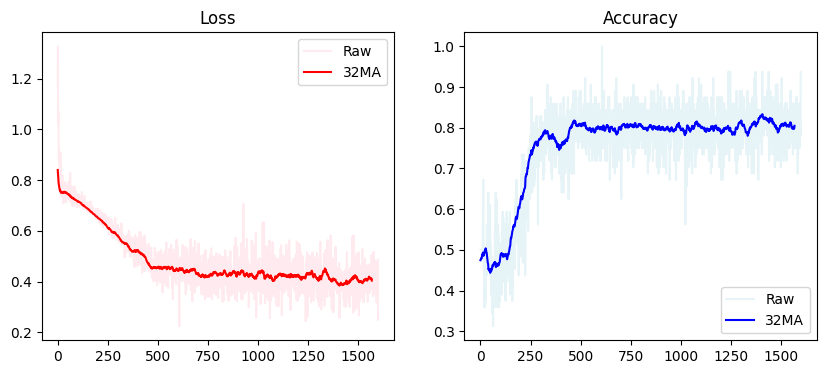

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate 5-point moving average
MA = 32
loss_ma = np.convolve(loss_hist, np.ones(MA)/MA, mode='valid')
acc_ma = np.convolve(acc_hist, np.ones(MA)/MA, mode='valid')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(loss_hist, 'pink', alpha=0.3, label='Raw')
ax1.plot(loss_ma, 'red', label=f'{MA}MA')
ax1.set_title('Loss')
ax1.legend()

ax2.plot(acc_hist, 'lightblue', alpha=0.3, label='Raw')
ax2.plot(acc_ma, 'blue', label=f'{MA}MA')
ax2.set_title('Accuracy')
ax2.legend()

plt.show()